<a href="https://colab.research.google.com/github/malacosteus/DLS/blob/main/churn/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Осень 2020</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/t/f50bc21dbe0e42dabe5e32a21f2e5235) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика. 

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
PATH_TO_DATA = '../content/drive/My Drive/Stepik_DLS/dz_prev_sem/'

In [7]:
data = pd.read_csv(PATH_TO_DATA+'train.csv')

In [8]:
data.sample(n=5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2178,61,98.45,6145.2,Male,0,Yes,Yes,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),0
1001,9,45.15,416.45,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,1
83,60,105.90,6396.45,Female,0,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4792,37,70.35,2552.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0
4280,2,93.85,196.75,Male,1,No,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1


In [9]:
# Количественные признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [10]:
len(data)

5282

In [11]:
nans = data.isna() #нет NaN'ов
tbl = nans.apply(pd.Series.value_counts)
tbl

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
False,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282


In [12]:
data.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

In [13]:
#есть ли среди num_cols такие, у кого тип данных "подозрительный"
objects = []
for col in data.dtypes.index:
  if (data.dtypes[col] == 'object') & (col in num_cols):
      objects.append(col)

objects

['TotalSpent']

In [19]:
#data['TotalSpent'].value_counts()

In [20]:
data[pd.to_numeric(data['TotalSpent'], errors='coerce').isnull()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [21]:
#Или так
# tbl3 = {}
# for col in objects:
#   if col in num_cols:
#     tbl3[col] = len(data[data[col].str.contains(" |\-|\?")])

# tbl3

In [23]:
#len(data[data['TotalSpent'].str.contains(" |\-|\?")])#есть "пустоты", 9шт

In [24]:
data['TotalSpent'] = data['TotalSpent'].replace(' ', '0').astype(float)

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

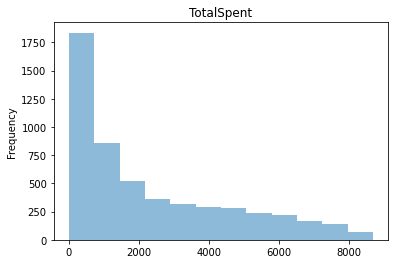

In [25]:
plt.title('TotalSpent')
ax = data['TotalSpent'].plot.hist(bins=12, alpha=0.5)

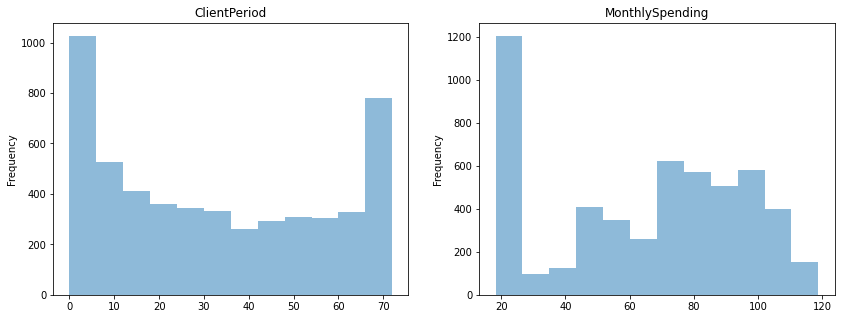

In [26]:
numerical = num_cols[:-1]

n=0
plt.figure(figsize=(14, 5))
for col in numerical:
  plt.subplot(1, 2, n+1)
  data[col].astype('float').plot.hist(bins=12, alpha=0.5)
  plt.title(col)
  n += 1

In [27]:
len(cat_cols)

16

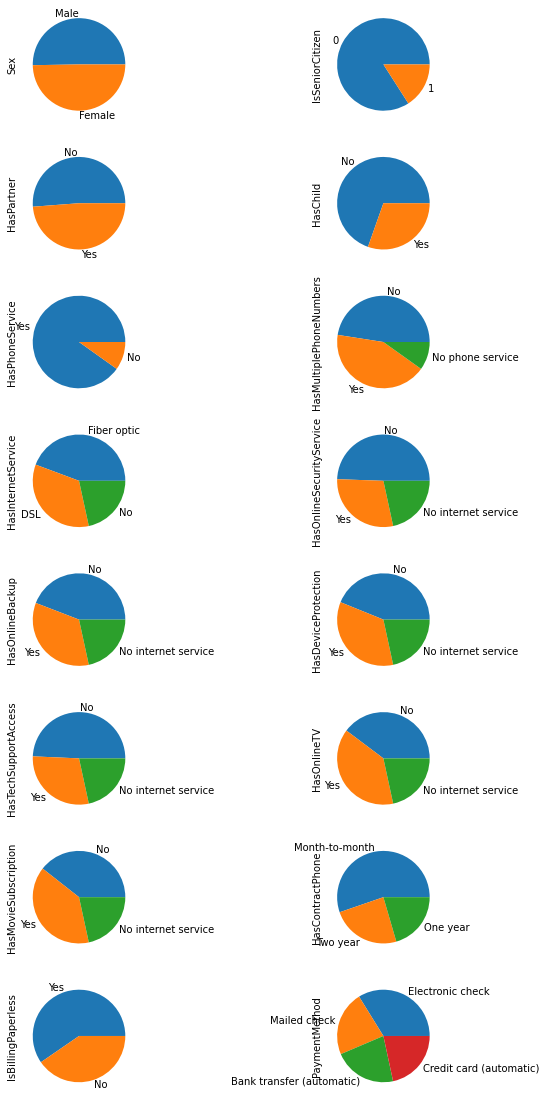

In [28]:
n=0
for col in cat_cols:
  plt.subplot(8, 2, n+1)
  data[col].value_counts().plot.pie(figsize=(10, 20))
  n += 1

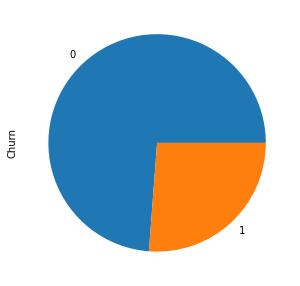

In [29]:
data[target_col].value_counts().plot.pie(figsize=(5, 5))

In [ ]:
#полагаю, что назвать такое соотношение классов откровенно несбалансированным нельзя (количество объектов одного класса не сильно превышает количество объектов другого класса
#(количество объектов меньшего класса не менее 10%))

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [30]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [ ]:
#Нормировка

In [31]:
scaled_features = data.copy()

In [32]:
col_names = num_cols
features = scaled_features[col_names].replace(' ', '0').astype('float')
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [33]:
scaled_features[col_names] = features

In [34]:
scaled_features.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,0.920767,-1.505447,-0.555852,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,1.613288,-1.294998,-0.183039,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,-1.279005,0.363737,-0.974768,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,-0.016173,0.476418,0.124519,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,1.124450,1.667856,1.970599,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
#OHE

In [35]:
scaled_features2 = scaled_features.copy()

In [36]:
enc = LabelEncoder()

scaled_features2[cat_cols] = scaled_features2[cat_cols].apply(lambda col: enc.fit_transform(col))    

In [37]:
scaled_features2.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,0.920767,-1.505447,-0.555852,1,0,1,1,1,0,2,1,1,1,1,1,1,1,0,3,0
1,1.613288,-1.294998,-0.183039,1,0,1,0,1,2,2,1,1,1,1,1,1,2,0,1,0
2,-1.279005,0.363737,-0.974768,1,0,0,0,1,0,1,0,0,0,2,0,0,0,1,2,1
3,-0.016173,0.476418,0.124519,0,1,1,0,1,2,1,0,0,2,0,0,0,0,0,3,0
4,1.124450,1.667856,1.970599,0,0,1,1,1,2,1,2,2,2,2,2,2,2,0,1,0


In [38]:
ohe = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(ohe.fit_transform(scaled_features2[cat_cols]).toarray())
scaled_features2 = scaled_features2.join(enc_df)
scaled_features2.drop(columns=cat_cols)
scaled_features2.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,0.920767,-1.505447,-0.555852,1,0,1,1,1,0,2,1,1,1,1,1,1,1,0,3,0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.613288,-1.294998,-0.183039,1,0,1,0,1,2,2,1,1,1,1,1,1,2,0,1,0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,-1.279005,0.363737,-0.974768,1,0,0,0,1,0,1,0,0,0,2,0,0,0,1,2,1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.016173,0.476418,0.124519,0,1,1,0,1,2,1,0,0,2,0,0,0,0,0,3,0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.124450,1.667856,1.970599,0,0,1,1,1,2,1,2,2,2,2,2,2,2,0,1,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#ну или просто вот так

In [39]:
scaled_features3 = scaled_features.copy()

In [40]:
df = pd.get_dummies(scaled_features3, columns = cat_cols)

In [41]:
df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Churn,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_DSL,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No,HasOnlineSecurityService_No internet service,HasOnlineSecurityService_Yes,HasOnlineBackup_No,HasOnlineBackup_No internet service,HasOnlineBackup_Yes,HasDeviceProtection_No,HasDeviceProtection_No internet service,HasDeviceProtection_Yes,HasTechSupportAccess_No,HasTechSupportAccess_No internet service,HasTechSupportAccess_Yes,HasOnlineTV_No,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.920767,-1.505447,-0.555852,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1
1,1.613288,-1.294998,-0.183039,0,0,1,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0
2,-1.279005,0.363737,-0.974768,1,0,1,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,-0.016173,0.476418,0.124519,0,1,0,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1
4,1.124450,1.667856,1.970599,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0


In [ ]:
#предобработка для тестовой выборки

In [42]:
data_test = pd.read_csv(PATH_TO_DATA+'test.csv')

In [43]:
scaled_features_test = data_test.copy()

In [44]:
col_names = num_cols
features_test = scaled_features_test[col_names].replace(' ', '0').astype('float')
scaler = StandardScaler().fit(features_test.values)
features_test = scaler.transform(features_test.values)

In [45]:
scaled_features_test[col_names] = features_test

In [46]:
scaled_features_test.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,0.394782,-0.274027,0.057688,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,-0.133958,1.147644,0.330847,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,-0.947404,0.401602,-0.695456,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,1.411590,0.326160,1.155787,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,1.574279,-1.481107,-0.383600,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


In [47]:
scaled_features2_test = scaled_features_test.copy()

In [48]:
df_test = pd.get_dummies(scaled_features2_test, columns = cat_cols)

In [49]:
df_test.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex_Female,Sex_Male,IsSeniorCitizen_0,IsSeniorCitizen_1,HasPartner_No,HasPartner_Yes,HasChild_No,HasChild_Yes,HasPhoneService_No,HasPhoneService_Yes,HasMultiplePhoneNumbers_No,HasMultiplePhoneNumbers_No phone service,HasMultiplePhoneNumbers_Yes,HasInternetService_DSL,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_No,HasOnlineSecurityService_No internet service,HasOnlineSecurityService_Yes,HasOnlineBackup_No,HasOnlineBackup_No internet service,HasOnlineBackup_Yes,HasDeviceProtection_No,HasDeviceProtection_No internet service,HasDeviceProtection_Yes,HasTechSupportAccess_No,HasTechSupportAccess_No internet service,HasTechSupportAccess_Yes,HasOnlineTV_No,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_Month-to-month,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_No,IsBillingPaperless_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.394782,-0.274027,0.057688,0,1,1,0,0,1,1,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0
1,-0.133958,1.147644,0.330847,0,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
2,-0.947404,0.401602,-0.695456,0,1,1,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
3,1.411590,0.326160,1.155787,1,0,1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0
4,1.574279,-1.481107,-0.383600,1,0,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0


In [50]:
X = df.drop(['Churn'], axis=1)

In [51]:
y = df[target_col]

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=4)

In [53]:
model = LogisticRegressionCV(cv=5, solver='liblinear', n_jobs=1, class_weight='balanced', scoring='roc_auc', refit=True)

In [ ]:
#del model

In [54]:
model.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=1, penalty='l2',
                     random_state=None, refit=True, scoring='roc_auc',
                     solver='liblinear', tol=0.0001, verbose=0)

In [55]:
model.C_

array([2.7825594])

In [56]:
model.score(X_val, y_val)

0.8537759391519515

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [62]:
!pip install catboost

In [63]:
from catboost import CatBoostClassifier, Pool

In [66]:
default_catboost = CatBoostClassifier(eval_metric='AUC', random_seed=4)

In [67]:
default_catboost.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

Learning rate set to 0.042134
0:	test: 0.8214311	best: 0.8214311 (0)	total: 48.9ms	remaining: 48.9s
1:	test: 0.8397062	best: 0.8397062 (1)	total: 51.9ms	remaining: 25.9s
2:	test: 0.8402270	best: 0.8402270 (2)	total: 54.9ms	remaining: 18.2s
3:	test: 0.8429873	best: 0.8429873 (3)	total: 57.5ms	remaining: 14.3s
4:	test: 0.8425462	best: 0.8429873 (3)	total: 60.1ms	remaining: 12s
5:	test: 0.8443217	best: 0.8443217 (5)	total: 62.6ms	remaining: 10.4s
6:	test: 0.8428930	best: 0.8443217 (5)	total: 65ms	remaining: 9.22s
7:	test: 0.8433013	best: 0.8443217 (5)	total: 67.5ms	remaining: 8.37s
8:	test: 0.8436082	best: 0.8443217 (5)	total: 70.1ms	remaining: 7.71s
9:	test: 0.8437307	best: 0.8443217 (5)	total: 72.7ms	remaining: 7.19s
10:	test: 0.8455671	best: 0.8455671 (10)	total: 75.4ms	remaining: 6.78s
11:	test: 0.8462666	best: 0.8462666 (11)	total: 77.9ms	remaining: 6.41s
12:	test: 0.8472179	best: 0.8472179 (12)	total: 80.4ms	remaining: 6.1s
13:	test: 0.8475671	best: 0.8475671 (13)	total: 82.9ms	rema

In [68]:
catboost2 = CatBoostClassifier(eval_metric='AUC', random_seed=4, verbose=0, learning_rate=4e-2, num_trees=500, depth=2)#2000

In [69]:
catboost2_train = Pool(data = X_train, label=y_train)

In [70]:
catboost2.fit(catboost2_train, eval_set=(X_val, y_val), use_best_model=True)

In [71]:
pred_class = catboost2.predict_proba(X_val)[:,-1]

In [72]:
metric = roc_auc_score(y_val, pred_class)

In [73]:
metric

0.8574758416751023

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [ ]:
#Лучший показатель 0.8578 с использованием CatBoostClassifier: num_trees=500, lr=4e-2, depth=2

# Предсказания

In [74]:
best_model = catboost2

In [76]:
X_test = df_test
subm2 = pd.read_csv(PATH_TO_DATA+'submission.csv', index_col=0)
subm2['Churn'] = best_model.predict_proba(X_test)[:,-1]
subm2.to_csv(PATH_TO_DATA+'subm2.csv', index_label=False, index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.